In [ ]:
from sklearn.preprocessing import LabelEncoder
from archive.explore_data import load_data
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [4]:
df = load_data()

# handling categorical data 
le = LabelEncoder()
df['encoded_type'] = le.fit_transform(df['type'])
print(df['encoded_type'] )

# features to include in model
features = ['step', 'amount', 'log_amount', 'oldbalanceOrg', 'newbalanceOrig','oldbalanceDest', 'newbalanceDest', 'encoded_type']

# train/test split
X = df[features]
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=42)


0         1
1         1
2         0
3         1
4         1
         ..
199994    3
199995    1
199996    0
199997    0
199998    1
Name: encoded_type, Length: 199999, dtype: int64


In [5]:
# train xgboost model - gradient boosting (weak -> strong)
non_fraud = (y_train == 0).sum()
fraud = (y_train == 1).sum()
model = XGBClassifier(
    scale_pos_weight=(non_fraud/fraud),
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

model.save_model("xgb_model.json")


In [6]:
# model's confidence for each prediction (fraud class probabilities)
y_pred_probs = model.predict_proba(X_test)[:, 1]

# prioritize recall because missing a fraud might cost you $1k vs mistakenly calling fraud would cost you $10 in reputation
# eval performance
threshold = .899
y_pred_custom = (y_pred_probs > threshold).astype(int)
y_pred = model.predict(X_test)
print("confusion matrix")
print(confusion_matrix(y_test, y_pred_custom))
print("classification report")
print(classification_report(y_test, y_pred_custom, digits=4))

confusion matrix
[[39934    10]
 [    4    52]]
classification report
              precision    recall  f1-score   support

           0     0.9999    0.9997    0.9998     39944
           1     0.8387    0.9286    0.8814        56

    accuracy                         0.9997     40000
   macro avg     0.9193    0.9642    0.9406     40000
weighted avg     0.9997    0.9997    0.9997     40000



In [7]:
# precision: % of all flagged predictions that are correct
# recall: % of all actual frauds that the model caught
# f1: maximize to balance precision and recall (2 * (Precision * recall)/ precision + recall)
# equal error rate (EER): where precision = recall
# precision_recall_curve returns arrays of precision/recall vals, one less threshold, account for that in f1 score calc
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

f1_scores = 2 * ((precision * recall)/(precision +recall+ 1e-8))
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
print(f"Best Threshold: {best_threshold}")
print(f"Precision at best threshold: {precision[best_index]:.4f}")
print(f"Recall at best threshold: {recall[best_index]:.4f}")
print(f"F1 Score at best threshold: {f1_scores[best_index]:.4f}")


Best Threshold: 0.9960446357727051
Precision at best threshold: 1.0000
Recall at best threshold: 0.8036
F1 Score at best threshold: 0.8911


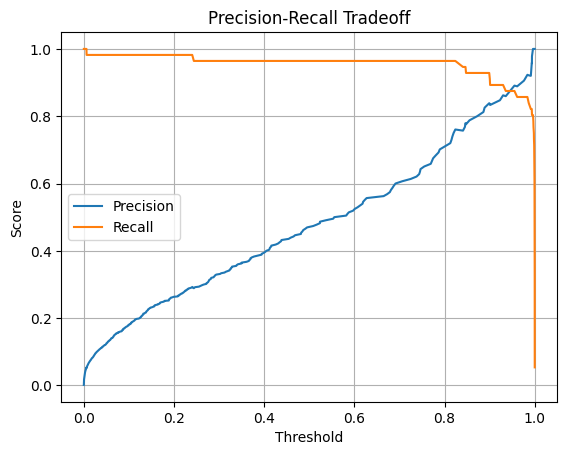

In [8]:
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Tradeoff")
plt.legend()
plt.grid()
plt.show()

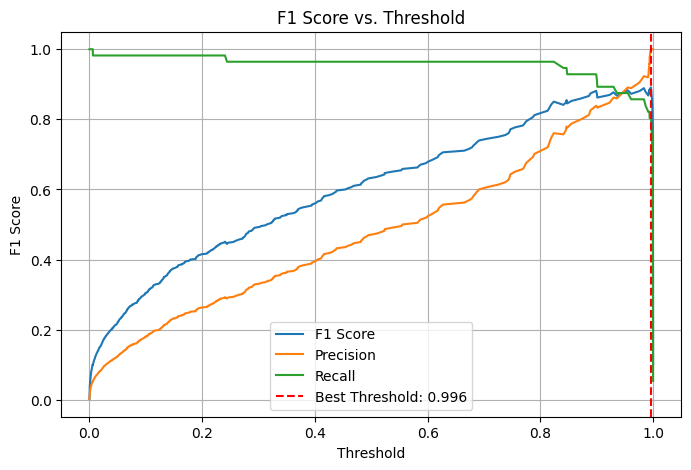

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold")
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.3f}')
plt.legend()
plt.grid()
plt.show()


In [11]:
joblib.dump(model, "xgb_fraud_model.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']